### 1. INSTALL / IMPORT LIBRARIES

In [1]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # (Adjust for your system as needed)
os.environ["OMP_NUM_THREADS"] = "1" # This is to avoid conflicts with Faiss (for MAC users)

import numpy as np
import faiss
import torch
from PyPDF2 import PdfReader
import openai

# We still import these in case you need them for displaying images, etc.
from transformers import CLIPProcessor, CLIPModel

# Assume these utility functions are available:
#   - encode_image_to_base64: converts a PIL image to a base64 string.
#   - search_index: given a Faiss index and a query vector, returns distances and indices.
#   - retrieve_context: given Faiss indices and metadata, returns the corresponding metadata items.
#   - call_gpt_4: calls GPT-4 (and, if needed, its vision mode) given a list of content pieces.
#   - extract_figures_from_pdf: extracts images (as PIL images) from a PDF.
from common_utils import (
    encode_image_to_base64,
    search_index,
    retrieve_context,
    call_gpt_4,
    extract_figures_from_pdf,
)

c:\Skola\Master's Thesis\masters-thesis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. CONFIGURE OPENAI & OTHER SETUPS

In [2]:
openai.api_key = os.environ.get("OPENAI_API_KEY")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Although we won’t use CLIP for embedding anymore, we load its processor/model
# in case you want to display images etc.
model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_id)

### Helper functions

In [3]:
# 
# We define two new functions:
# 
# 1. `embed_texts`: a helper that calls OpenAI’s text-embedding-model.
# 2. `generate_image_summary`: a helper that sends an image (encoded as base64) along with a prompt to GPT‑4,
#    asking for a detailed summary of the image.

# %%
def embed_texts(texts):
    """
    Given a list of strings, returns a list of embedding vectors using OpenAI's new embeddings API.
    Here we use the 'text-embedding-3-small' model as an example.
    """
    response = openai.embeddings.create(
        input=texts,
        model="text-embedding-3-small",  # or another model if preferred
        encoding_format="float"
    )
    embeddings = [d.embedding for d in response.data]
    return embeddings

def generate_image_summary(image):
    """
    Given a PIL image, this function:
      1. Converts the image to a base64 string.
      2. Prepares a message payload that sends the image to GPT-4 along with a prompt requesting a detailed summary.
      3. Returns the generated summary text.
    
    Note: This function assumes that your `call_gpt_4` helper can handle both image and text parts.
    """
    base64_str = encode_image_to_base64(image)
    # Build a message payload that includes the image (as a data URL) and the prompt.
    content = [
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{base64_str}"}
        },
        {
            "type": "text",
            "text": "Please provide a detailed summary of the above image."
        }
    ]
    summary = call_gpt_4(content)
    return summary.strip()


### 4. PROCESS THE PDF (TEXT + IMAGES)

In [4]:
PDF_FILE = "../knowledge/catsanddogs.pdf"

text_data = []
image_data = []

# Extract text from each page
reader = PdfReader(PDF_FILE)
num_pages = len(reader.pages)
for i in range(num_pages):
    page = reader.pages[i]
    page_text = page.extract_text()
    if page_text and page_text.strip():
        text_data.append({
            "text": page_text.strip(),
            "page_number": i + 1
        })

# Extract images from the PDF
all_images = extract_figures_from_pdf(PDF_FILE)
print(f"Extracted {len(all_images)} images.")
for i, pil_img in enumerate(all_images):
    image_data.append({
        "image": pil_img,
        "image_number": i + 1
    })

Extracted 4 images.


### 5. CREATE EMBEDDINGS FOR TEXT AND IMAGE CHUNKS

In [5]:
all_metadata = []
all_embeddings = []

#### 5A. Embed all text chunks

In [6]:
if text_data:
    texts_list = [td["text"] for td in text_data]
    text_embeddings = embed_texts(texts_list)
    for i, emb in enumerate(text_embeddings):
        all_metadata.append({
            "type": "text",
            "content": text_data[i]["text"],
            "page_number": text_data[i]["page_number"]
        })
        all_embeddings.append(emb)

#### 5B. Embed all images

[{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'Please provide a detailed summary of the above image.'}]
[{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'Please provide a detailed summary of the above image.'}]
[{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'Please provide a detailed summary of the above image.'}]
[{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'Please provide a detailed summary of the above image.'}]

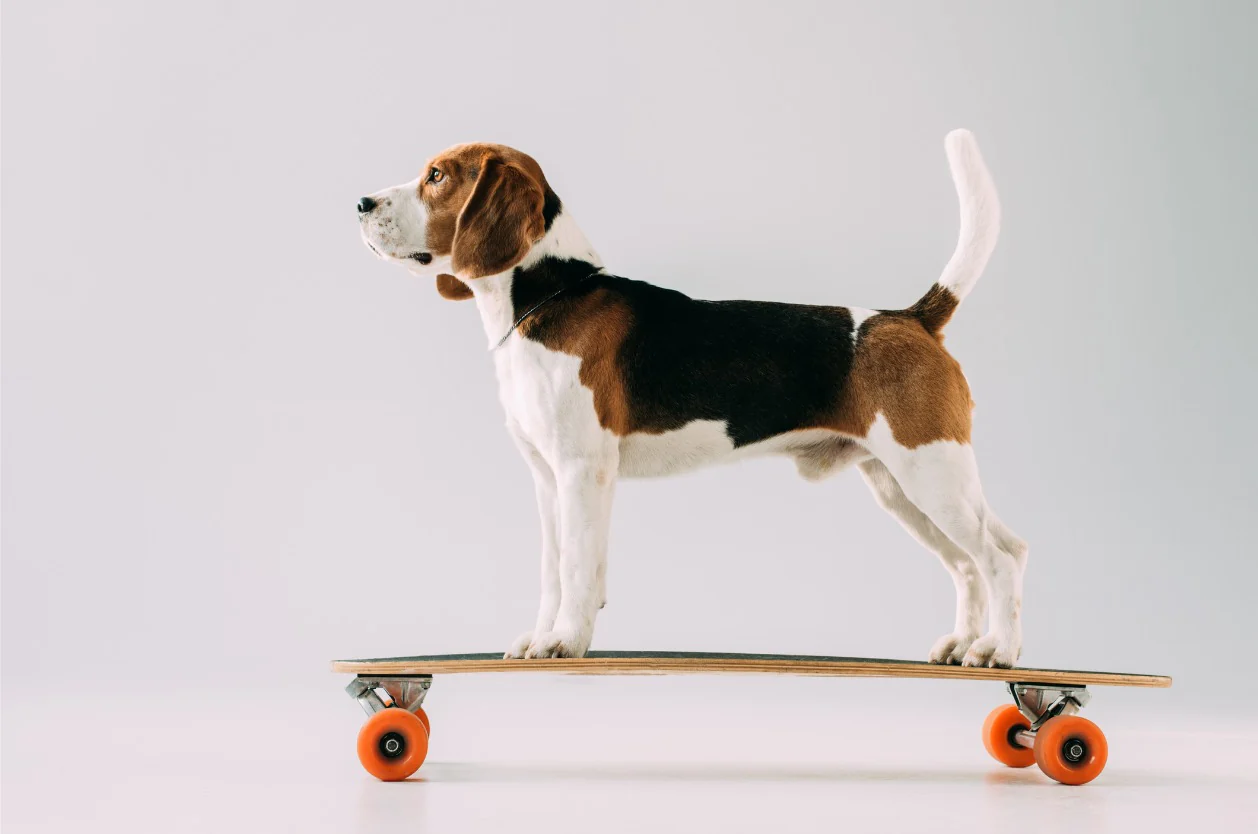
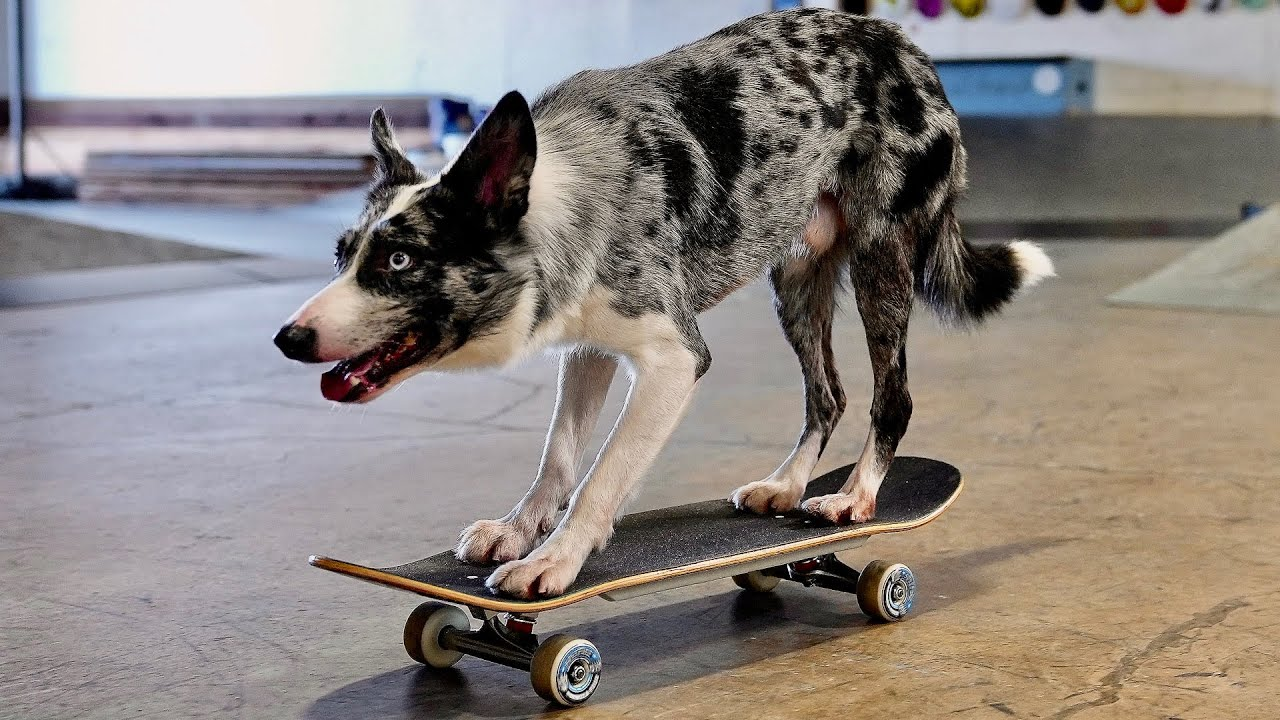
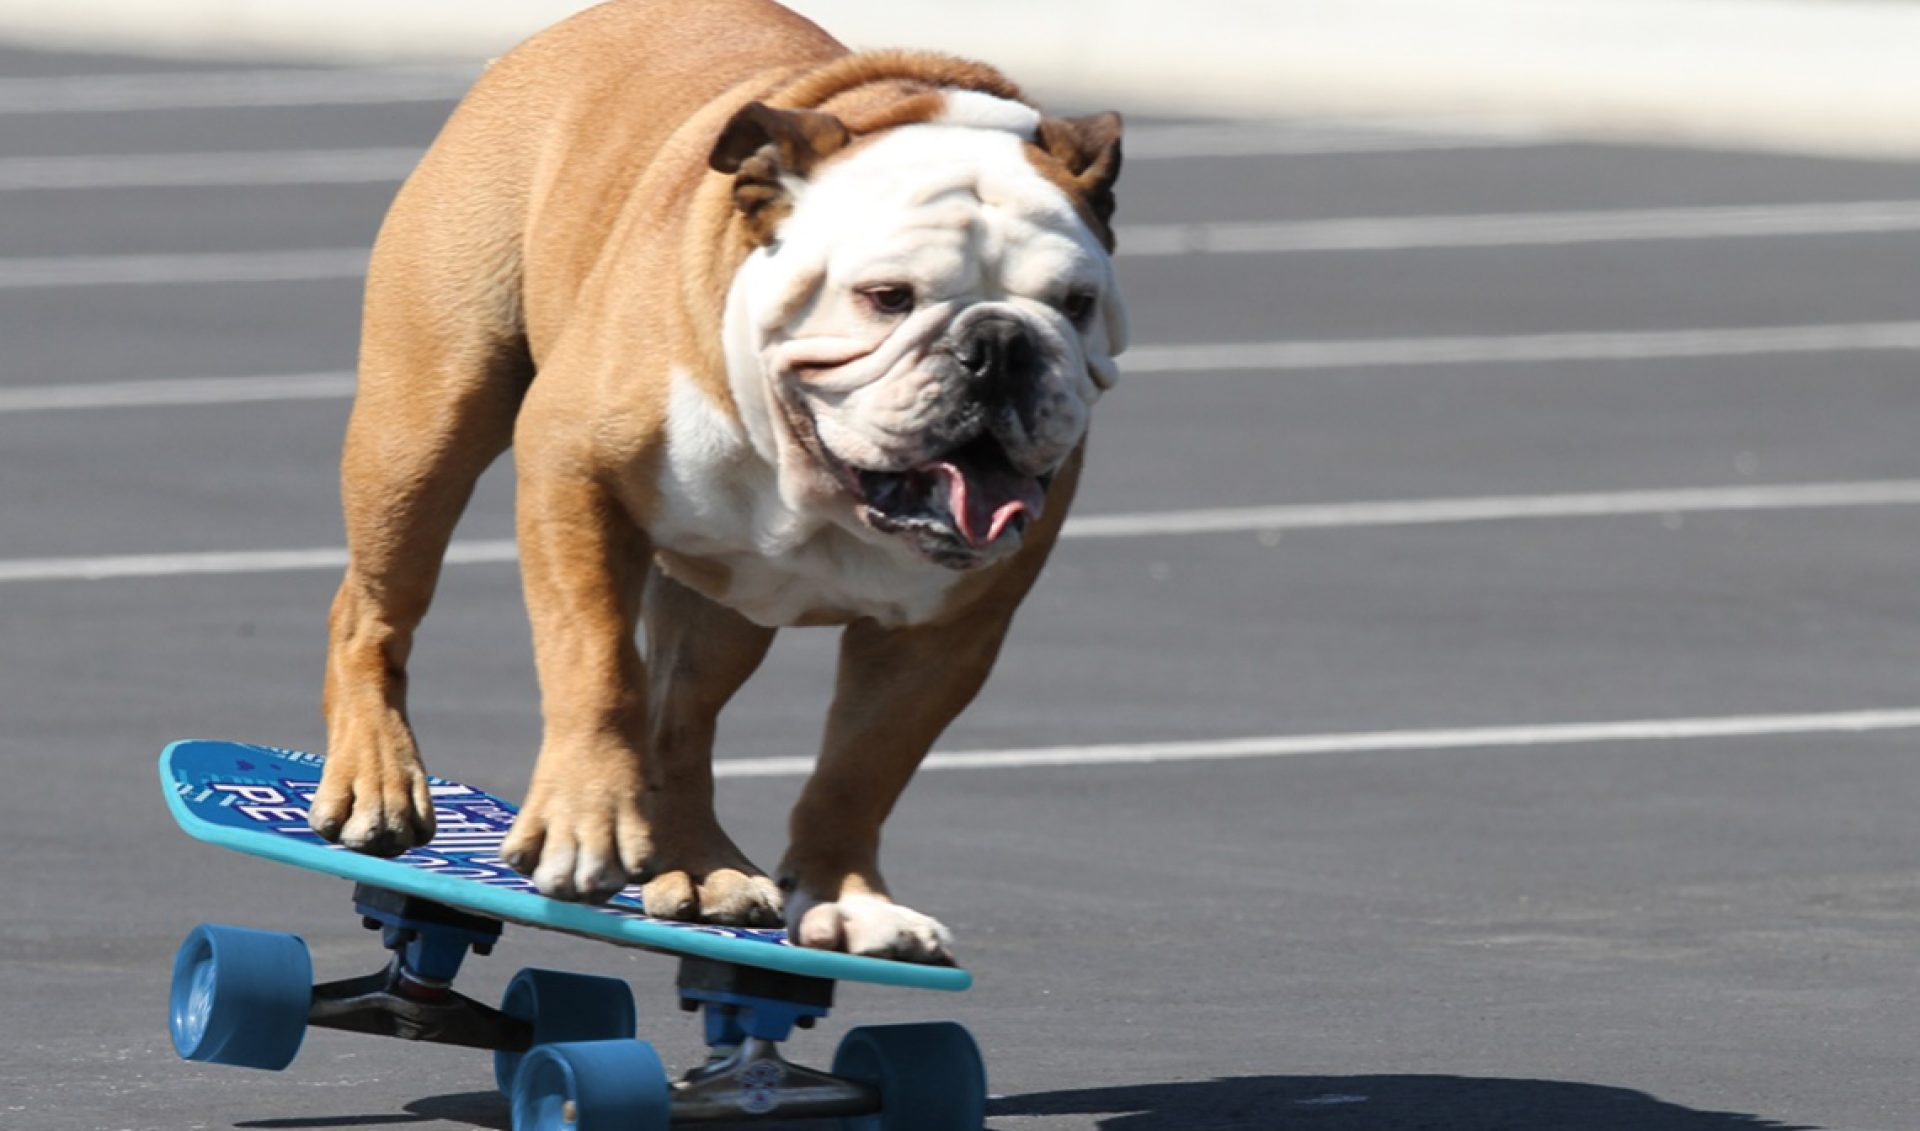
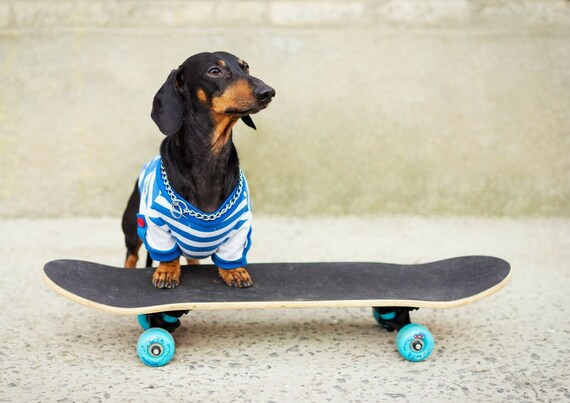

In [7]:
if image_data:
    for i, img_info in enumerate(image_data):
        pil_img = img_info["image"]
        # Generate a text summary for the image.
        image_summary = generate_image_summary(pil_img)
        # Embed the summary using the ada embedder.
        summary_embedding = embed_texts([image_summary])[0]
        # Convert the original image to base64 for metadata.
        base64_str = encode_image_to_base64(pil_img)
        all_metadata.append({
            "type": "image",
            "content": base64_str,  # storing the original image
            "image_number": img_info["image_number"]
            # Note: The generated summary is used only for computing the embedding.
        })
        all_embeddings.append(summary_embedding)

# Convert list of embeddings to a NumPy array (of type float32)
all_embeddings = np.array(all_embeddings).astype('float32')
embedding_dimension = all_embeddings.shape[1]

### 6. BUILD & POPULATE FAISS

In [8]:
index = faiss.IndexFlatIP(embedding_dimension)
index.add(all_embeddings)

### 7. QUERY PIPELINE (RETRIEVAL + GENERATION)

In [9]:
def answer_query(user_query, top_k=3):
    # Step 1: Embed the user query using the ada embedder.
    query_emb = embed_texts([user_query])
    
    # Step 2: Retrieve the top_k similar items from the Faiss index.
    distances, faiss_indices = search_index(index, np.array(query_emb).astype('float32'), top_k=top_k)
    retrieved_items = retrieve_context(faiss_indices, all_metadata)
    print("Distances:", distances)

    # Step 3: Build the message payload.
    # The payload includes the user’s query and then, for each retrieved item,
    # either a text snippet (for text items) or the original image (for images).
    user_content = []
    user_content.append({
        "type": "text",
        "text": f"User query: {user_query}"
    })
    for item in retrieved_items:
        if item["type"] == "text":
            user_content.append({
                "type": "text",
                "text": f"(page {item['page_number']}) {item['content'][:500]}..."
            })
        elif item["type"] == "image":
            base64_str = item["content"]
            user_content.append({
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{base64_str}"}
            })

    # Step 4: Call GPT‑4 with the constructed payload and return its answer.
    answer = call_gpt_4(user_content)
    return answer

### 8. EXAMPLE USAGE

Distances: [[0.41141343 0.36716056 0.35136384]]
[{'type': 'text', 'text': 'User query: What are the dog names?'}, {'type': 'text', 'text': '(page 1) This\n \nis\n \nwhat\n \ndogs\n \nlike\n \nto\n \ndo.\n \n \nHere\n \nis\n \nRuffy,\n \na\n \ndog\n \nthat\n \nis\n \nblack\n \nand\n \nwhite...'}, {'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': '(page 2) This\n \nis\n \nBunny ,\n \na\n \nbulldog\n \nthat\n \nlikes\n \nto\n \ndo\n \nwhat\n \nthe\n \nimage\n \nillustrates.\n \n \nWeiner\n \nis\n \na\n \ndog\n \nthat\n \nlikes\n \nto\n \nwear\n \na\n \nsweater\n \nwhile\n \nhe\n \ndoes\n \nhis\n \nfavourite\n \nactivity ,\n \nas\n \nyou\n \ncan\n \nsee\n \non\n \nthe\n \nimage....'}]

Q: What are the dog names?
A: It looks like you're describing different dogs and their activities. Here are the names mentioned:

1. Ruffy - a black and white dog.
2. Bunny - a bulldog.
3. Weiner - a dog that wears a sweater.

If you need more names or information about dogs, feel fre
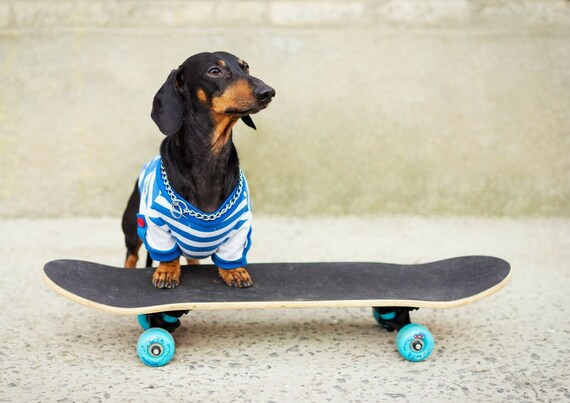

In [10]:
user_query_1 = "What are the dog names?"
response_1 = answer_query(user_query_1, top_k=3)
print("\nQ:", user_query_1)
print("A:", response_1)